In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as sch


In [2]:
import pandas as pd
df = pd.read_csv('ML_spotify_data.csv')
df.head()

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          10000 non-null  object 
 1   artists       10000 non-null  object 
 2   popularity    10000 non-null  int64  
 3   danceability  10000 non-null  float64
 4   valence       10000 non-null  float64
 5   energy        10000 non-null  float64
 6   explicit      10000 non-null  int64  
 7   key           10000 non-null  int64  
 8   liveness      10000 non-null  float64
 9   loudness      10000 non-null  float64
 10  speechiness   10000 non-null  float64
 11  tempo         10000 non-null  float64
dtypes: float64(7), int64(3), object(2)
memory usage: 937.6+ KB


In [4]:
df.isnull().sum()

name            0
artists         0
popularity      0
danceability    0
valence         0
energy          0
explicit        0
key             0
liveness        0
loudness        0
speechiness     0
tempo           0
dtype: int64

In [5]:
# Numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", num_cols)

# Categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", cat_cols)


Numerical Columns: ['popularity', 'danceability', 'valence', 'energy', 'explicit', 'key', 'liveness', 'loudness', 'speechiness', 'tempo']
Categorical Columns: ['name', 'artists']


### Preprocessing

In [6]:
# Drop duplicates
df = df.drop_duplicates()

In [7]:
# Select features for clustering
features = ['danceability','valence','energy','liveness',
            'loudness','speechiness','tempo']

X = df[features]

In [8]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### K-Means Clustering

Finding optimal number of clusters (KMeans + Silhouette)

In [9]:
wcss, sil_scores = [], []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

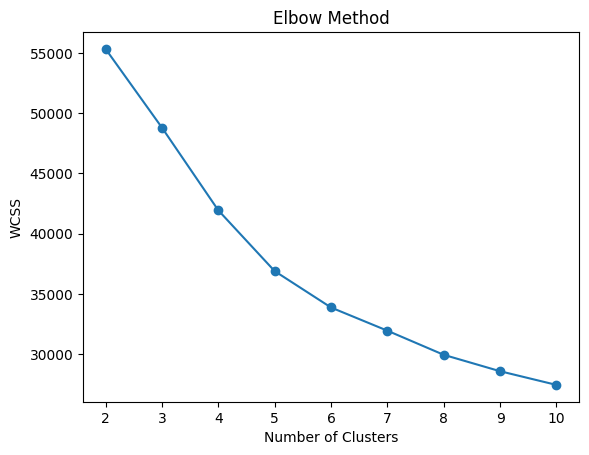

In [10]:
# Elbow method
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

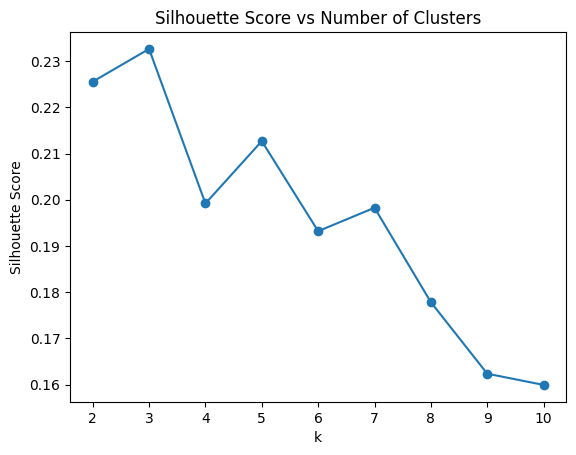

In [11]:
# Silhouette scores
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

In [12]:
# Fit final model (choose best k from above)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


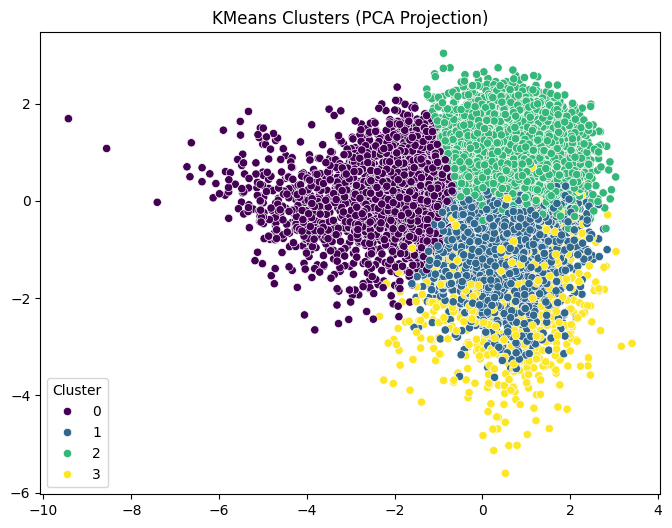

In [13]:
# PCA for visualization(pca has reduces data to 2D for visualisations)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette="viridis")
plt.title("KMeans Clusters (PCA Projection)")
plt.show()

In [14]:
#  Cluster profiling
cluster_profile = df.groupby('Cluster')[features].mean()
print(cluster_profile)

         danceability   valence    energy  liveness   loudness  speechiness  \
Cluster                                                                       
0            0.418518  0.272116  0.253982  0.148187 -16.154788     0.043368   
1            0.461617  0.464209  0.754510  0.183383  -6.938217     0.074594   
2            0.694783  0.703092  0.628101  0.152644  -8.753538     0.090697   
3            0.493799  0.504412  0.714888  0.728394  -8.963187     0.157132   

              tempo  
Cluster              
0        106.228581  
1        141.940277  
2        111.643952  
3        120.356648  


In [15]:
# Popularity distribution by cluster
popularity_profile = df.groupby('Cluster')['popularity'].mean()
print(popularity_profile)

Cluster
0    35.662005
1    38.557510
2    38.517540
3    34.297647
Name: popularity, dtype: float64


| **Cluster** | **Danceability** | **Valence (Mood)**      | **Energy**         | **Liveness**     | **Loudness (dB)**       | **Tempo (BPM)**   | **Cluster Meaning**                        |
| ----------- | ---------------- | ----------------------- | ------------------ | ---------------- | ----------------------- | ----------------- | ------------------------------------------ |
| **0**       | 0.42 (Low)       | 0.27 (Sad/Negative)     | 0.25 (Very Low)    | 0.15 (Low)       | -16.15 (Very Quiet)     | 106 (Slow-Mid)    | Calm, acoustic, sad songs                  |
| **1**       | 0.46 (Medium)    | 0.46 (Neutral-Positive) | 0.75 (Very High)   | 0.18 (Low)       | -6.94 (Loud)            | 142 (Fastest)     | Energetic, fast-paced party/EDM tracks     |
| **2**       | 0.69 (High)      | 0.70 (Happy/Positive)   | 0.63 (Medium-High) | 0.15 (Low)       | -8.75 (Moderately Loud) | 112 (Mid-Fast)    | Upbeat, danceable pop songs                |
| **3**       | 0.49 (Medium)    | 0.50 (Neutral-Positive) | 0.71 (High)        | 0.73 (Very High) | -8.96 (Moderately Loud) | 120 (Medium-Fast) | Live performance, energetic concert tracks |


### Hierarchical Clustering

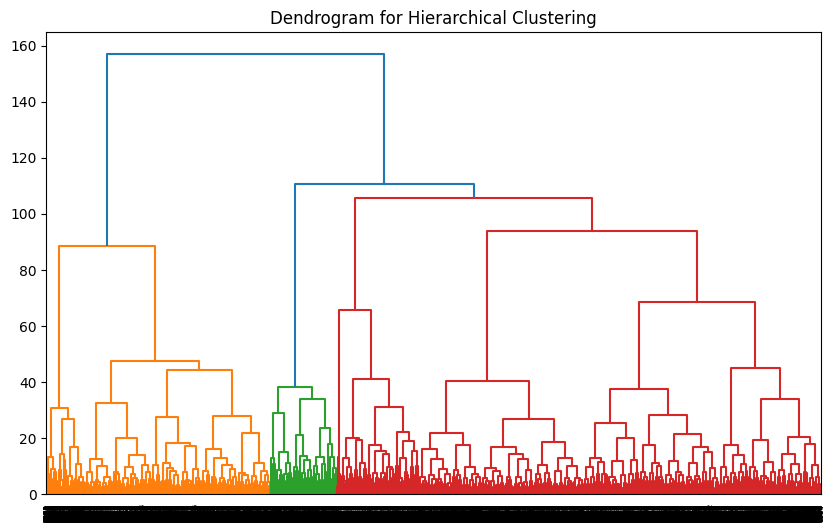

In [16]:
# Plot dendrogram
plt.figure(figsize=(10,6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title("Dendrogram for Hierarchical Clustering")
plt.show()

In [18]:
# Fit Agglomerative Clustering (choose same k as KMeans for comparison)
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
df['Cluster_HC'] = hc.fit_predict(X_scaled)

In [19]:
# Evaluate
from sklearn.metrics import silhouette_score
print("Hierarchical Silhouette Score:", silhouette_score(X_scaled, df['Cluster_HC']))

Hierarchical Silhouette Score: 0.19005682653740263


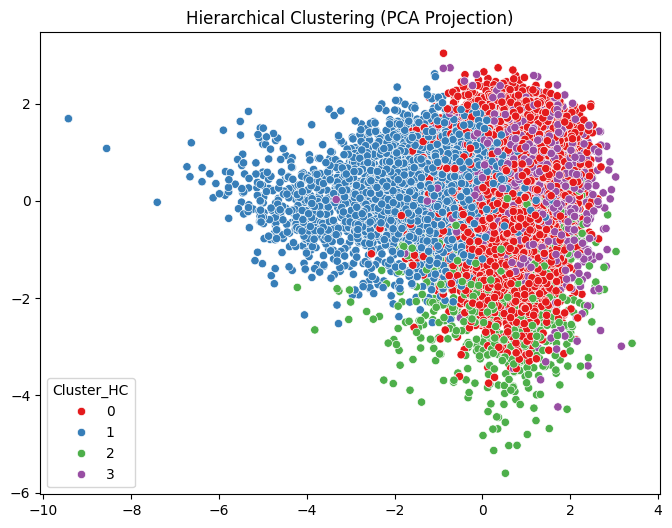

In [20]:
# PCA Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster_HC'], palette="Set1")
plt.title("Hierarchical Clustering (PCA Projection)")
plt.show()

### DBSCAN

In [21]:
# Fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

In [22]:
# Handle noise (-1 are outliers)
valid_clusters = df[df['Cluster_DBSCAN'] != -1]
if len(valid_clusters['Cluster_DBSCAN'].unique()) > 1:
    score = silhouette_score(valid_clusters[features], valid_clusters['Cluster_DBSCAN'])
    print("DBSCAN Silhouette Score:", score)
else:
    print("DBSCAN found too few clusters for silhouette score.")

DBSCAN Silhouette Score: -0.13102628426561672


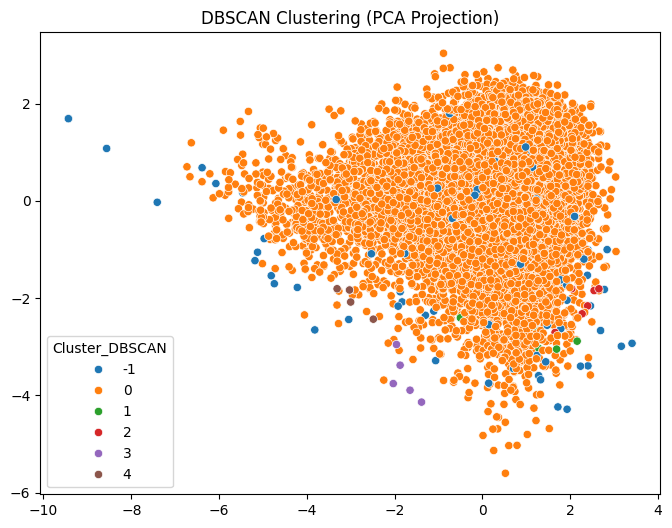

In [23]:
# PCA Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster_DBSCAN'], palette="tab10")
plt.title("DBSCAN Clustering (PCA Projection)")
plt.show()

### Gaussian Mixture Model (GMM)

In [24]:
# Fit GMM
gmm = GaussianMixture(n_components=4, random_state=42)
df['Cluster_GMM'] = gmm.fit_predict(X_scaled)

In [25]:
# Evaluate
print("GMM Silhouette Score:", silhouette_score(X_scaled, df['Cluster_GMM']))

GMM Silhouette Score: 0.04500827775779968


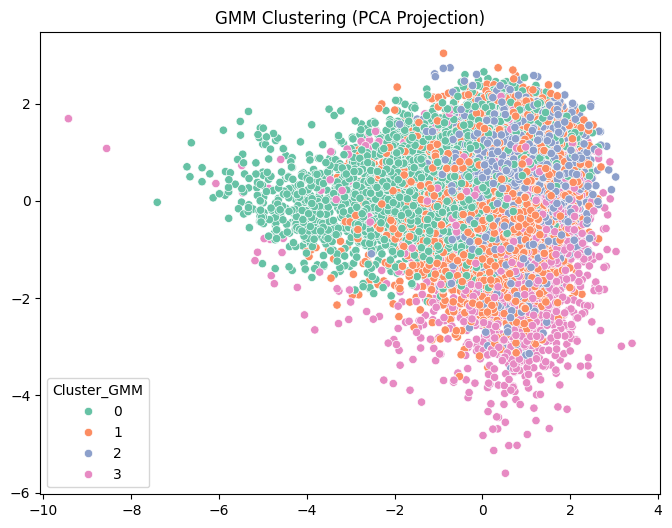

In [26]:
# PCA Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster_GMM'], palette="Set2")
plt.title("GMM Clustering (PCA Projection)")
plt.show()

### Comparison Table of Models

In [27]:
# Collect scores
results = {
    "Model": ["KMeans", "Hierarchical", "DBSCAN", "GMM"],
    "Silhouette Score": [
        silhouette_score(X_scaled, df['Cluster']),
        silhouette_score(X_scaled, df['Cluster_HC']),
        silhouette_score(valid_clusters[features], valid_clusters['Cluster_DBSCAN']) 
            if len(valid_clusters['Cluster_DBSCAN'].unique()) > 1 else None,
        silhouette_score(X_scaled, df['Cluster_GMM'])
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


          Model  Silhouette Score
0        KMeans          0.199199
1  Hierarchical          0.190057
2        DBSCAN         -0.131026
3           GMM          0.045008


Silhouette score gives us a measure of cluster quality:

+1 → perfectly separated clusters

~0 → overlapping clusters

-1 → wrong clustering (points assigned to wrong cluster)